In [4]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from random import randint

import _pickle as pickle 
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
#Loading the token file into memory

def load_doc(filename):
	file = open(filename, 'r', encoding="utf=8", errors="ignore")
	text = file.read()
	file.close()
	return text

filename = "text/Flickr30k.token.token"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000092795.jpg#0	Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg#1	Two young , White males are outside near many bushes .
1000092795.jpg#2	Two men in green shirts are standing in a yard .
1000092795.jpg#3	A man in a blue shirt standing in a garden .


In [6]:
#Loading description: for each line, this script split the lines, and take the first token as id of the image 
#and the rest as description.
#
#1000092795.jpg#3     A man in a blue shirt standing in a garden .
#image_id, image_desc = tokens[0], tokens[1:]
#


def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 31692 


In [7]:
list(descriptions.keys())[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [8]:
#Actual Descriptions
descriptions['1000092795']

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young , White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [9]:
descriptions['10002456']

['Several men in hard hats are operating a giant pulley system .',
 'Workers look down from up above on a piece of equipment .',
 'Two men working on a machine wearing hard hats .',
 'Four men on top of a tall structure .',
 'Three men on a large rig .']

In [10]:
#Now we clean descriptions, converting all letters to lowe case, removing punctuation
#removing hanging, numbers etc.
#
#Workers look down from up above on a piece of equipment .
#became
#workers look down from up above on piece of equipment
#
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [11]:
descriptions['10002456']

['several men in hard hats are operating giant pulley system',
 'workers look down from up above on piece of equipment',
 'two men working on machine wearing hard hats',
 'four men on top of tall structure',
 'three men on large rig']

In [12]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 19712


In [13]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [14]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + '.jpg')
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'train.txt')

In [15]:
#Loading Training set
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset
filename = 'text/trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 31592


In [16]:
# Path for image folder
images = 'images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [17]:
# Below file conatains the names of images to be used in train data
train_images_file = 'text/trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = []

for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [18]:
# Below file conatains the names of images to be used in test data
test_images_file = 'text/testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = []

for i in img: 
    if i[len(images):] in test_images: #
        test_img.append(i)

In [19]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=31592


In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the Inception v3 model/InceptionResNetV2
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [21]:
#Load the Inception v3 model / InceptionResNetV2 Model
#model = InceptionV3(weights='imagenet')
model = InceptionResNetV2(weights='imagenet')

In [22]:
# Create a new model, by removing the last layer (output layer) from the inception model
model_new = Model(model.input, model.layers[-2].output)

In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [24]:
# Call the funtion to encode all the train images - Execute this Once, it will take a while
# Pickle is used to save the encoded data
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

import _pickle as pickle 

with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [26]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [27]:
#Load the encoded data
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=31592


In [28]:
#Load the encoded data
train_features = load(open("encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=100


In [29]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

157960

In [30]:
# Set a treshold to consider only words which occur at least 5 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 19700 -> 7639


In [31]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [32]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

7640

In [37]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length 
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 74


In [38]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                
                    
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
        
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [35]:
# Load Glove word vectors
glove_dir = 'vectors'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'vector_small.txt'), encoding="utf-8", errors="ignore")
for line in f:
    values = line.split()
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
   # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix.shape

(7640, 200)

In [41]:
inputs1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 74, 200)      1528000     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [43]:
model.layers[2]

In [44]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [46]:
model.optimizer.learning_rate = 0.01
epochs = 5
number_pics_per_bath = 1
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

In [129]:
model.load_weights('model_weights/finalloss.h5')

In [115]:
#Loading encoded test images
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [116]:
images = 'images/'

In [117]:
#Using a greedy algorithm to build the captions
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [118]:
f = open("text/testDesc.txt", "r")
ExpectedDescription= f.readlines()

In [119]:
#Testing:
#Validation policy: if the auto generated caption has at leas one word in common with the reference caption, 
#we consider the caption "Accepted and increase the var score"

In [130]:
import re
z=0
score=0

for z in range(99):
    z=z+1
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,1536))
    x=plt.imread(images+pic)
    actualCaption = greedySearch(image)
    caption= actualCaption.split(" ")
    expectedCaption = ExpectedDescription[z]
    reference = expectedCaption.split(" ")
    localScore=0
    for word in caption:
        if word in reference:
            localScore=localScore+1
    if localScore>0:
        score=score+1     
        

In [132]:
print("Accepted Captions" ,score , "/100" )

Accepted Captions 73 /100


In [2]:
#Some Example of Good and Wrong Captions:

In [ ]:
#About People:

87


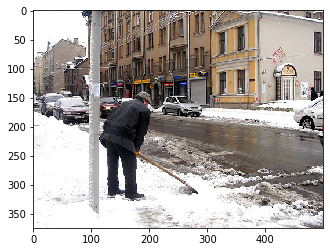

Image: man shovels snow off of the road


In [72]:
value =87
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

79


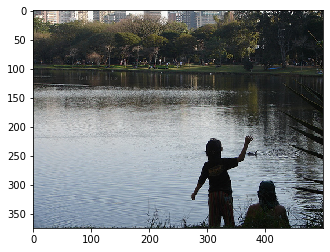

Image: young boy in blue shirt and jeans is standing on the edge of the water


In [56]:
value =79
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

4


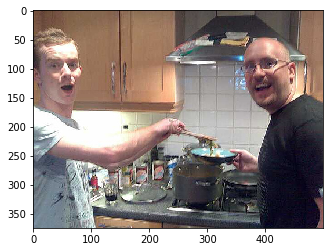

Image: man in white shirt is cooking food


In [60]:
value =4
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

83


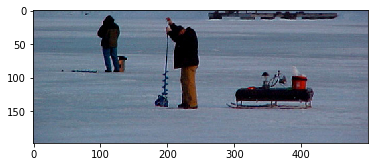

Image: two people are walking on the snow with their snowboards


In [69]:
value =83
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

65


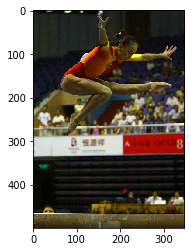

Image: gymnast is performing on the balance beam


In [70]:
value =65
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

88


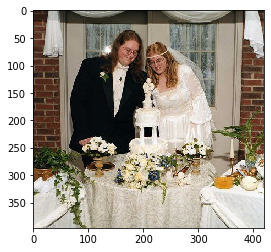

Image: bride and groom are standing around table


In [82]:
value =88
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

5


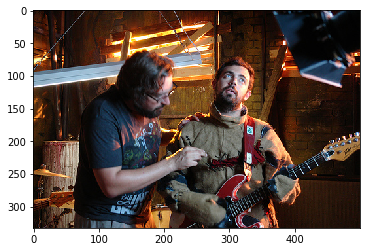

Image: man in white shirt is playing guitar


In [88]:
value =5
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

55


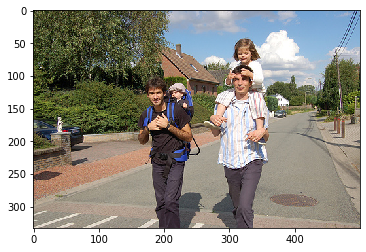

Image: two men are walking down the street


In [84]:
value =55
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

13


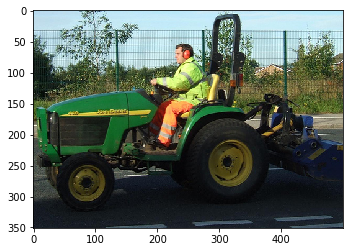

Image: man in blue shirt is driving tractor


In [99]:
value =13
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

In [ ]:
#About animals:

34


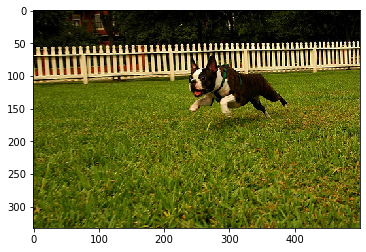

Image: dog is jumping over hurdle


In [62]:
value =34
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

90


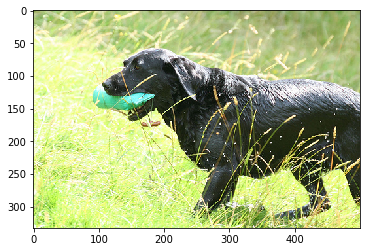

Image: black dog is running through the grass


In [64]:
value =90
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))

72


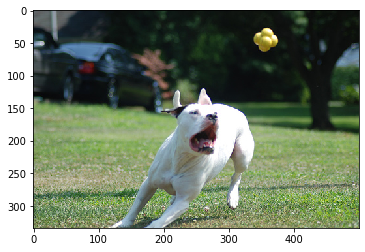

Image: dog is running through the grass


In [109]:
value =72
print(value)
pic = list(encoding_test.keys())[value]
image = encoding_test[pic].reshape((1,1536))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image:",greedySearch(image))